**QUESTION 1**

In [96]:
import torch
import torchvision
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

**DATA PRE-PROCESSING**

In [97]:
#resnet50 model
model = torchvision.models.resnet50(pretrained=True)
model.eval()

# Preprocessing Image
preprocess = torchvision.transforms.Compose([torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])

#appending images into a list
images=[]
imgs=[]
processed_imgs=[]
paths=[]
for i in range(5):
    path='D:/sem6/deeplearning-AI5100/assignment3/images/i'+str(i+1)+'.jpg'
    paths.append(path)
    images.append(Image.open(path))
    imgs.append(plt.imread(path))
    processed_imgs.append(preprocess(images[i]).unsqueeze_(0))


C:\Users\manas\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\manas\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [98]:
#normalize and flatten tensor 
def normalize_flat_image(img):
    normalize_tens = torchvision.transforms.Compose([ torchvision.transforms.Normalize(mean = [ 0., 0., 0. ],
                                                    std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                            torchvision.transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                    std = [ 1., 1., 1. ]),
                            ])
    output = normalize_tens(img)[0]
    output = output.detach().numpy().transpose(1, 2, 0)
    
    #flatten
    flat_tens = output[:,:,0]+ output[:,:,1]+ output[:,:,2]
    
    #normalize
    flat_tens = (flat_tens - np.min(flat_tens))/ (np.max(flat_tens)- np.min(flat_tens))
    return flat_tens

**VANILLA BACK PROPAGATION:**

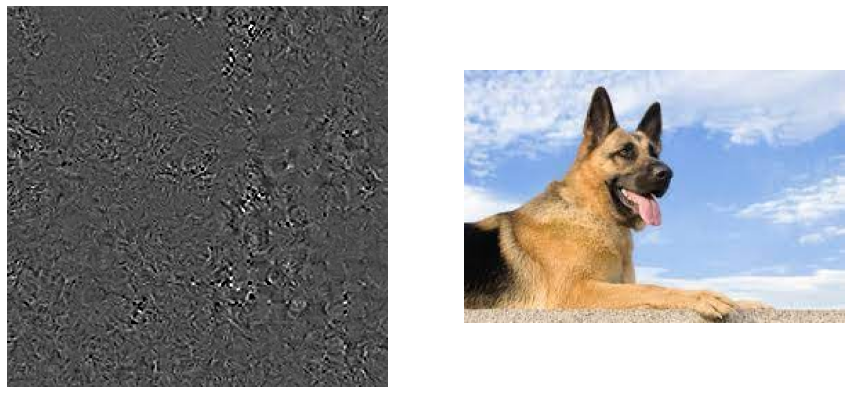

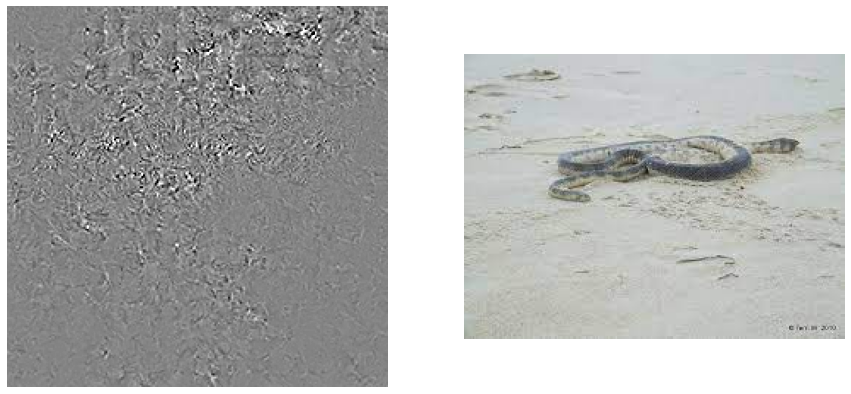

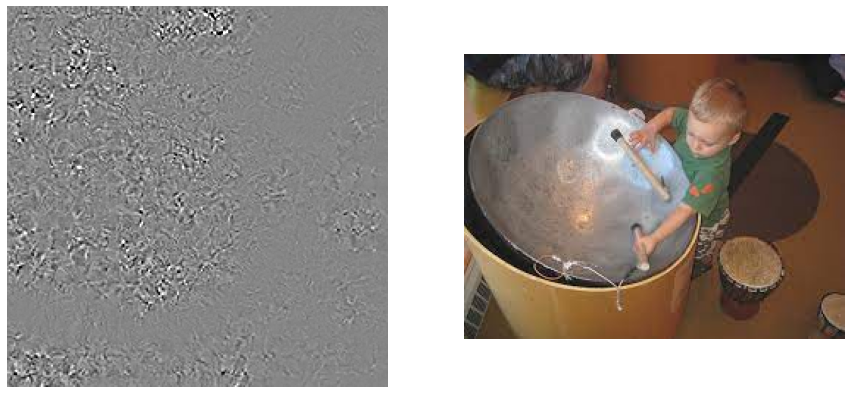

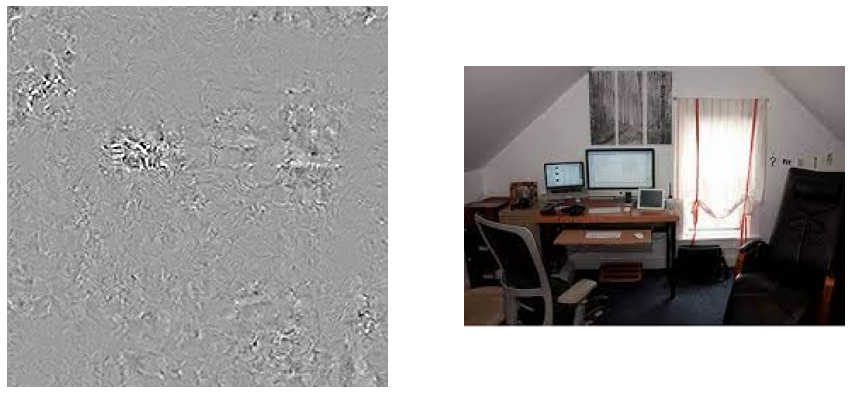

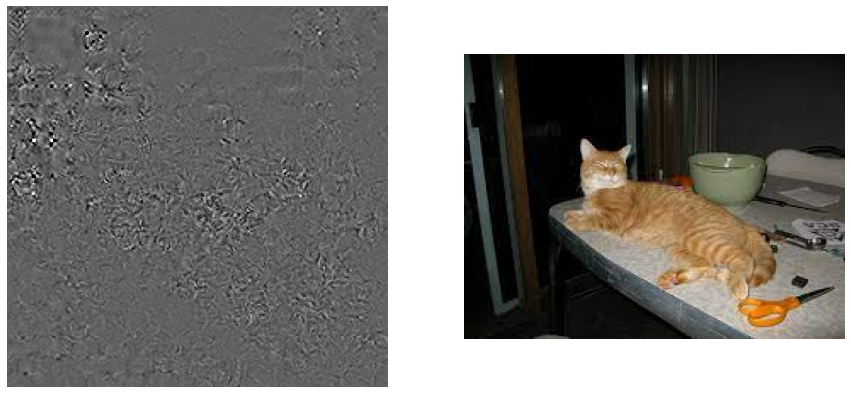

In [99]:
for i in range(5):
    processed_imgs[i].requires_grad = True
    # forward
    output = model(processed_imgs[i])
    neuron_idx = torch.argmax(output)
    # backprop
    output[0, neuron_idx].backward()
    grads = processed_imgs[i].grad

    #visualize vanilla backprop results
    f = plt.figure(figsize=(15,45))
    #plot of backprop output
    plt.subplot(1,2,1)
    plt.imshow(normalize_flat_image(grads),vmin=0.3, vmax=0.7, cmap="gray")
    plt.axis("off")

    #plot of actual image
    plt.subplot(1,2,2)
    plt.imshow(imgs[i])
    plt.axis("off")


**GUIDED BACK PROPAGATION:**

In [100]:
def relu_hook_function(module, grad_in, grad_out):
    if isinstance(module, torch.nn.ReLU):
        return (torch.clamp(grad_in[0], min=0.),)

In [101]:
for i, module in enumerate(model.modules()):
    if isinstance(module, torch.nn.ReLU):
        print(model.named_modules())
        module.register_backward_hook(relu_hook_function)

<generator object Module.named_modules at 0x000001F200053760>
<generator object Module.named_modules at 0x000001F2000527A0>
<generator object Module.named_modules at 0x000001F2000527A0>
<generator object Module.named_modules at 0x000001F2000527A0>
<generator object Module.named_modules at 0x000001F2000527A0>
<generator object Module.named_modules at 0x000001F2000527A0>
<generator object Module.named_modules at 0x000001F2000527A0>
<generator object Module.named_modules at 0x000001F2000527A0>
<generator object Module.named_modules at 0x000001F2000527A0>
<generator object Module.named_modules at 0x000001F2000527A0>
<generator object Module.named_modules at 0x000001F2000527A0>
<generator object Module.named_modules at 0x000001F2000527A0>
<generator object Module.named_modules at 0x000001F2000527A0>
<generator object Module.named_modules at 0x000001F2000527A0>
<generator object Module.named_modules at 0x000001F2000527A0>
<generator object Module.named_modules at 0x000001F2000527A0>
<generat

C:\Users\manas\AppData\Roaming\Python\Python310\site-packages\torch\nn\modules\module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


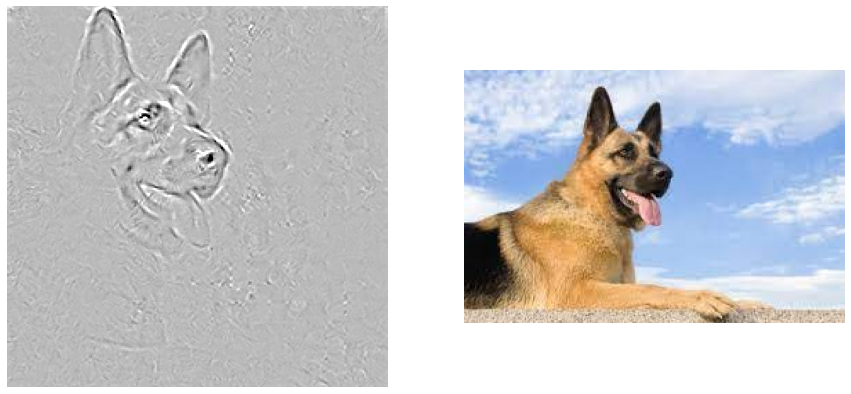

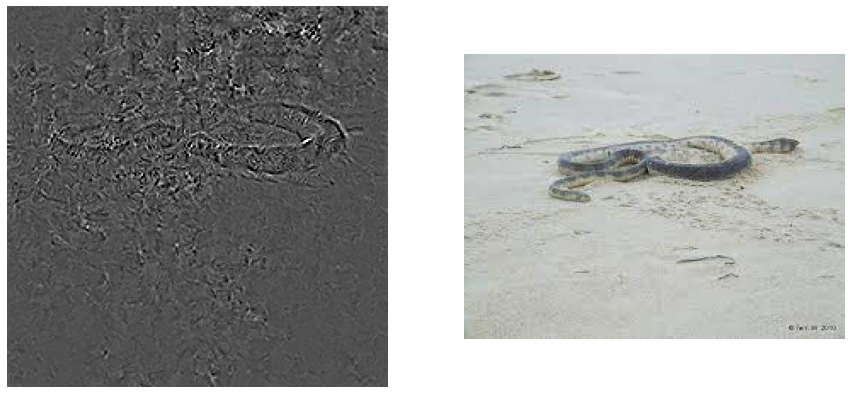

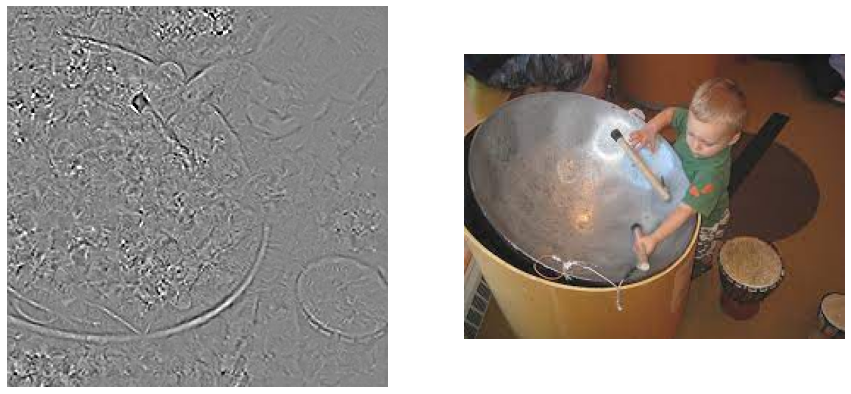

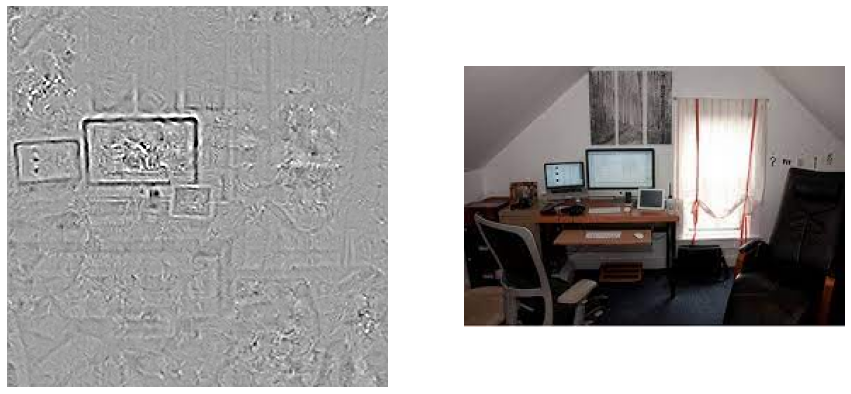

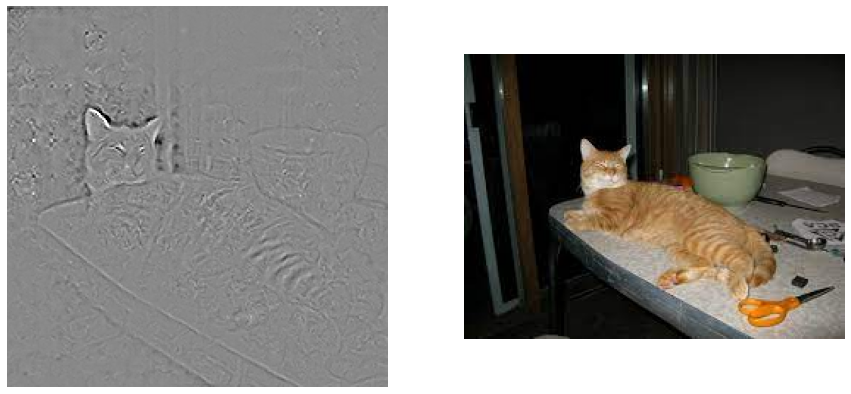

In [102]:
for i in range(5):
    processed_imgs[i].requires_grad = True
    # forward
    output = model(processed_imgs[i])
    neuron_idx = torch.argmax(output)
    # backprop
    output[0, neuron_idx].backward()
    grads = processed_imgs[i].grad

    #plot of guided backprop output
    f = plt.figure(figsize=(15,45))
    plt.subplot(1,2,1)
    plt.imshow(normalize_flat_image(grads),vmin=0.3, vmax=0.7, cmap="gray")
    plt.axis("off")

    #plot of actual image
    plt.subplot(1,2,2)
    plt.imshow(imgs[i])
    plt.axis("off")


**CLASS ACTIVATION MAP**

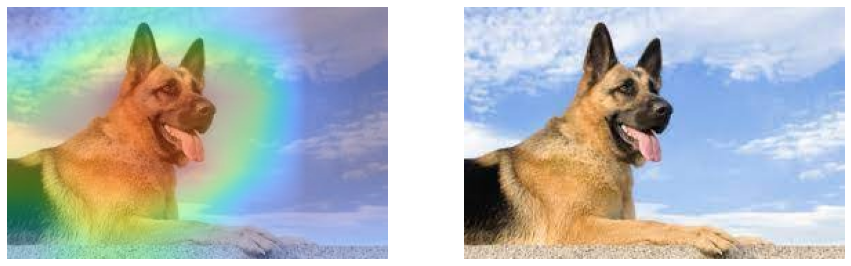

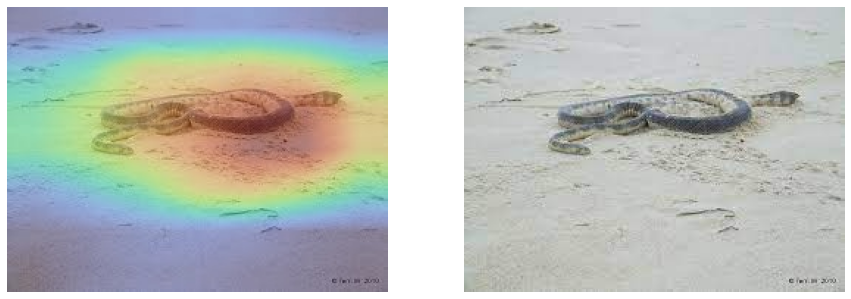

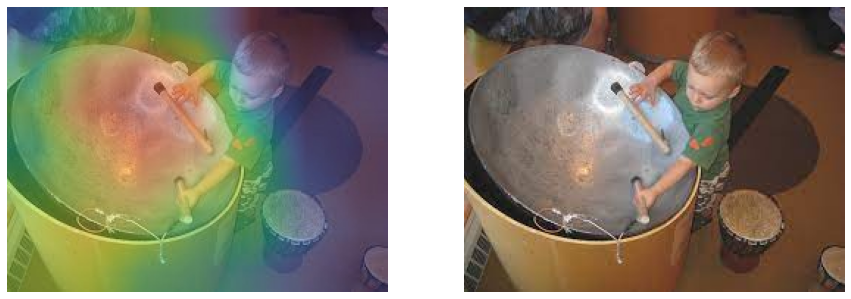

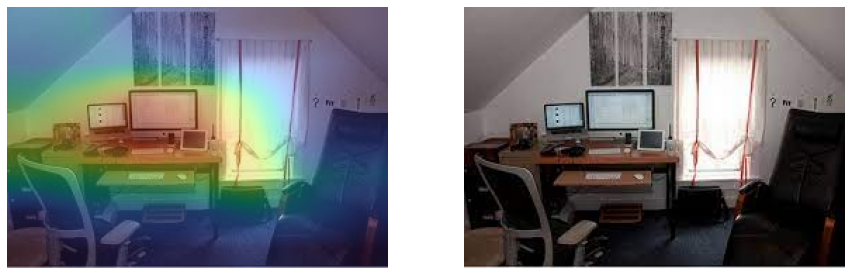

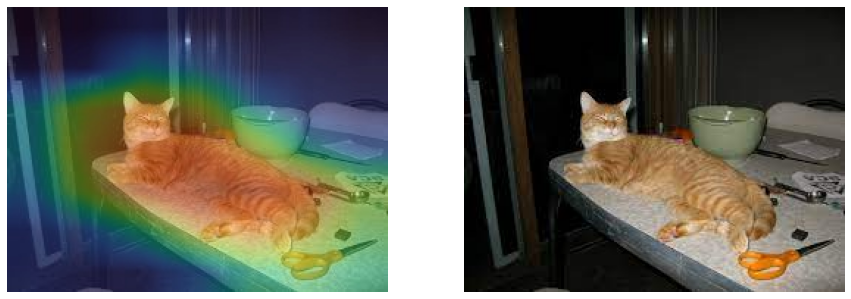

In [103]:


from torch.autograd import Variable
from torch.nn import functional as F
import cv2
import os

for i in range(5):
    model = torchvision.models.resnet50(pretrained=True)
    name_fconv = 'layer4'
    model.eval()
    fblobs = []
    def hook_feature(module, input, output):
      fblobs.append(output.data.cpu().numpy())

    model._modules.get(name_fconv).register_forward_hook(hook_feature)

    # softmax weight
    parameters = list(model.parameters())
    sftmx_wgt = np.squeeze(parameters[-2].data.numpy())

    def returnCAM(feature_conv, sftmx_wgt, class_idx):
      # generate the class activation maps
      sample_sizzeup = (256, 256)
      bz, nc, height, width = feature_conv.shape
      output_cam = []

      for indx in class_idx:
        cam = sftmx_wgt[indx].dot(feature_conv.reshape((nc, height*width)))
        cam = cam.reshape(height, width)
        cam -= np.min(cam)
        cam /= np.max(cam)
        cam = np.uint8(255 * cam)
        output_cam.append(cv2.resize(cam, sample_sizzeup))

      return output_cam


    # load image
    img = Variable(processed_imgs[i])
    output = model(img)


    hx = F.softmax(output, dim=1).data.squeeze()
    probs, indx = hx.sort(0, True)
    probs = probs.numpy()
    indx = indx.numpy()

    #implement CAM
    CAMs = returnCAM(fblobs[0], sftmx_wgt, [indx[0]])

    img = cv2.imread(paths[i])
    height, width, _ = img.shape
    heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_TURBO)
    result = heatmap * 0.4 + img * 0.6
    #save img in CAM.jpg
    cv2.imwrite('CAM.jpg', result)

    #read saved img
    cam_result=plt.imread('CAM.jpg')


    #plot CAM output
    f = plt.figure(figsize=(15,45))
    plt.subplot(1,2,1)
    plt.imshow(cam_result)
    plt.axis('off')
    plt.subplot(1,2,2)
 
    #plot actual image
    plt.imshow(imgs[i])
    plt.axis("off")
    plt.show()
    os.remove('CAM.jpg')
    

**QUESTION 2**

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation
from IPython.display import HTML
np.random.seed(19680801)

In [105]:
#function to minimize is f(x,y)= 10 * x**2 + y**2
def f(x, y):
    return 10 * x**2 + y**2

# gradient of the function f(x,y)= 10 * x**2 + y**2 with respect to x(df(x,y)/dx)= 20x, wrt to y(df(x,y)/dy)=2y respectively
def func_gradient(x, y):
    return np.array([20 * x, 2 * y])

In [106]:
# Define number of iterations
num_iterations = 100

**VANILLA BACK PROPAGATION:**

In [107]:
def vanilla_sgd(x, y, z,learning_rate,num_iterations):
  for i in range(num_iterations):
    # Calculate the gradient at the current point
    grad = func_gradient(x[-1], y[-1])
    # Update the point.
    x_next = x[-1] - learning_rate * grad[0]
    y_next = y[-1] - learning_rate * grad[1]
    # Add next point to its corresponding list
    x.append(x_next)
    y.append(y_next)
    z.append(f(x_next, y_next))
  return x, y, z


**SGD MOMENTUM**

In [108]:
def sgd_momentum(x, y, z,momentum,learning_rate,num_iterations):
  vx=0
  vy=0

  for i in range(num_iterations):
    # Calculate the gradient at the current point
    grad = func_gradient(x[-1], y[-1])

    #update velocity
    vx=momentum * vx - learning_rate * grad[0]
    vy=momentum * vy - learning_rate * grad[1]

    # Update the point.
    x_next = x[-1] +vx
    y_next = y[-1] +vy

    # Add next point to its corresponding list
    x.append(x_next)
    y.append(y_next)
    z.append(f(x_next, y_next))
  return x, y, z

**NESTEROV MOMENTUM**

In [109]:
def nesterov_momentum(x, y, z,momentum,learning_rate,num_iterations):
  vx=0
  vy=0

  for i in range(num_iterations):
    # Calculate the gradient at the current point
    grad = func_gradient(x[-1]+momentum*vx, y[-1]+momentum*vy)

    #update velocity
    vx=momentum * vx -learning_rate*grad[0]
    vy=momentum * vy -learning_rate*grad[1]

    # Update the point.
    x_next = x[-1] +vx
    y_next = y[-1] +vy
    
    # Add next point to its corresponding list
    x.append(x_next)
    y.append(y_next)
    z.append(f(x_next, y_next))
  return x, y, z

**ADA GRAD**

In [110]:
def adagrad(x, y, z,eps,learning_rate,num_iterations):
  grad_sq=[0.0,0.0]
  for i in range(num_iterations):
    # Calculate the gradient at the current point
    grad = func_gradient(x[-1], y[-1])

    
    grad_sq[0]+= grad[0]**2
    grad_sq[1]+= grad[1]**2


    # Update the point.
    x_next = x[-1] -learning_rate*grad[0]/(np.sqrt(grad_sq[0])+eps)
    y_next = y[-1] -learning_rate*grad[1]/(np.sqrt(grad_sq[1])+eps)
    
    # Add next point to its corresponding list
    x.append(x_next)
    y.append(y_next)
    z.append(f(x_next, y_next))
  return x, y, z

**RMS PROP**

In [111]:
def RMSprop(x, y, z,momentum,eps,learning_rate,num_iterations):
  grad_sq=[0.0,0.0]
  for i in range(num_iterations):
    # Calculate the gradient at the current point
    grad = func_gradient(x[-1], y[-1])

    
    grad_sq[0]=  momentum*grad_sq[0]+(1-momentum)*(grad[0]**2)
    grad_sq[1]= momentum*grad_sq[1]+(1-momentum)*(grad[1]**2)


    # Update the point.
    x_next = x[-1] -learning_rate*grad[0]/(np.sqrt(grad_sq[0])+eps)
    y_next = y[-1] -learning_rate*grad[1]/(np.sqrt(grad_sq[1])+eps)
    
    # Add next point to its corresponding list
    x.append(x_next)
    y.append(y_next)
    z.append(f(x_next, y_next))
  return x, y, z

**VISUALIZATION**

In [112]:
# Define the update function for the animation
def update(iteration_num, data, plott):
  for line, points in zip( plott,data):
    line.set_data(points[0:2, :iteration_num])
    line.set_3d_properties(points[2, :iteration_num])
    line.set_marker("o")
  return plott

C:\Users\manas\AppData\Local\Temp\ipykernel_9740\811764985.py:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)


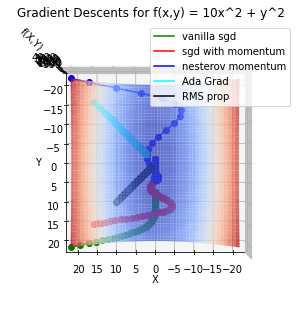

In [113]:
# Create a 3D plot of the function

fig = plt.figure()
ax = p3.Axes3D(fig)

x = np.linspace(-20, 20, 100)
y = np.linspace(-20, 20, 100)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)


ax.plot_surface(X, Y, Z, cmap='coolwarm', alpha=0.8)
ax.view_init(90, 90)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('f(X,Y)')
plt.title('Gradient Descents for f(x,y) = 10x^2 + y^2')

#x1,y1,z1 contains the path(sequence of points) gradient descent algorithm takes. 
# Initialize x1,y1,z1 to the values corresponding to starting point. 


#vanilla_sgd hyper parameters
x1 = [20.0]
y1 = [20.0]
z1 = [f(20, 20)]
learning_rate = 0.005
#vanilla_sgd path 
xa, ya, za=vanilla_sgd(x1, y1, z1,learning_rate,num_iterations)

#sgd_momentum hyper parameters
x1 = [15]
y1 = [15]
z1 = [f(15, 15)]
learning_rate = 0.001
momentum=0.9
#sgd_momentum path
xb, yb, zb=sgd_momentum(x1, y1, z1,momentum,learning_rate,num_iterations)



#nesterov_momentum hyper parameters
x1 = [20]
y1 = [-20]
z1 = [f(20, -20)]
learning_rate = 0.01
momentum=0.9
#nesterov_momentum path
xc, yc, zc=nesterov_momentum(x1, y1, z1,momentum,learning_rate,num_iterations)


#adagrad hyper parameters
x1 = [15]
y1 = [-15]
z1 = [f(15, -15)]
learning_rate = 0.99
eps=0.0001
#adagrad path
xd, yd, zd=adagrad(x1, y1, z1,eps,learning_rate,num_iterations)


#RMSprop hyperparameters
x1 = [10]
y1 = [10]
z1 = [f(10, 10)]
learning_rate = 0.1
momentum=0.9
eps=1e-8
#RMSprop path
xe, ye, ze=RMSprop(x1, y1, z1,momentum,eps,learning_rate,num_iterations)

data=np.array([[xa,ya,za],[xb,yb,zb],[xc,yc,zc],[xd,yd,zd],[xe,ye,ze]])
colors=['green','red','blue','cyan','black']
plots=['vanilla sgd','sgd with momentum','nesterov momentum','Ada Grad','RMS prop']
point = [ax.plot(d[0, 0:1], d[1, 0:1], d[2, 0:1],colors[i],label=plots[i])[0]  for i,d in enumerate(data)]

ax.legend(point,plots,loc=1)
plt.rcParams['animation.html'] = 'html5'
# Animate the optimization process
anim = animation.FuncAnimation(fig, update, num_iterations, fargs=(data, point),
                                   interval=100, blit=True, repeat=True)
anim


